In [1]:
#
%matplotlib inline
import matplotlib
import matplotlib_inline.backend_inline
import arviz as az
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
matplotlib_inline.backend_inline.set_matplotlib_formats("svg", "pdf", "retina")  # For export
import sys 
sys.path.append("../src/")
import seaborn as sns 
import warnings
warnings.filterwarnings("ignore")
from cycler import cycler
az.style.use(["science"])
nice_fonts = {
        # Use LaTeX to write all text
        "font.family": "serif",
        # Always save as 'tight'
        "savefig.bbox" : "tight",
        "savefig.pad_inches" : 0.05,
        "ytick.right" : True,
        "font.serif" : "Times New Roman",
        "mathtext.fontset" : "dejavuserif",
        "axes.labelsize": 15,
        "font.size": 15,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 12,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        # Set line widths
        "axes.linewidth" : 0.5,
        "grid.linewidth" : 0.5,
        "lines.linewidth" : 1.,
        # Remove legend frame
        "legend.frameon" :False,
        # color-blind friendly cycle designed using https://colorcyclepicker.mpetroff.net/
        # see preview and check for colorblindness here https://coolors.co/107591-00c0bf-f69a48-fdcd49-8da798-a19368-525252-a6761d-7035b7-cf166e
        'axes.prop_cycle': cycler(color=['#107591','#00c0bf','#f69a48','#fdcd49','#8da798','#a19368','#525252','#a6761d','#7035b7','#cf166e'])
         
}
matplotlib.rcParams.update(nice_fonts)
az.style.use(["science",  "arviz-doc", 'tableau-colorblind10'])

In [2]:
from utils.data import DatasetObjective
from darts import TimeSeries
from baselines.backtesting import BacktestingForecast

In [ ]:
from utils.hparams import  hparams
from utils.load_data import load_uk_data, load_substation_data
from utils.hparams import hparams
data_UK = load_uk_data(add_ghi=True).select_dtypes(exclude='object')
data_PT = load_substation_data(add_ghi=True).select_dtypes(exclude='object')
hparams.update({'window_size':96})
hparams.update({'horizon':48})
hparams.update({'encoder_type':'SeasonalNaive'})
hparams.update({'time_varying_known_categorical_feature': ['DAYOFWEEK', 'DAY', 'HOUR', 'Session']}),
hparams.update({'time_varying_known_feature': ['Ghi']})
hparams.update({'time_varying_unknown_feature': ['NetLoad-Ghi']})
hparams.update({'targets':['NetLoad']}) #'Load',
hparams.update({'latent_size': 256, 'depth': 2, 'batch_size': 64, 'k': 20, 'dropout': 0.1786342451901633 
                })

Compute load ghi feature
Total data sample: 66955
Missing data sample: 14213
 percentage of Missing data sample: 0.2122769023971324
 
Total data sample after cleaning: 52771
Missing data sample after cleaning: 384
 percentage of data loss : 0.21184377567022628


In [9]:
import scipy.signal as signal
import plotly.graph_objects as go
import plotly.express as px
data=data_PT['2018-8':'2022'].copy()
data['NetLoad']=signal.medfilt(data.NetLoad.values, 5)
data=data.reset_index().drop_duplicates(subset='timestamp')
data=data.drop(columns=[ 'index'])

columns = list(data.columns)[1:]
data['timestamp'] = pd.to_datetime(data['timestamp'], utc=True).dt.tz_localize(None)
data=TimeSeries.from_dataframe(data, 'timestamp', columns, fill_missing_dates=True).pd_dataframe()

In [ ]:
n_rows=1
fig = px.scatter(data.reset_index(), x='timestamp', y='NetLoad')
fig.update_xaxes(matches=None, showticklabels=True, visible=True)
fig.update_layout(margin=dict(l=60, r=10, t=20, b=50))
fig.update_layout(template="plotly_white", font=dict(size=10))
fig.update_annotations(font_size=10)
fig.update_layout(autosize=True, height=150 * n_rows)
fig.show()                   

## Multiple Seasonal-Trend decomposition using LOESS (MSTL)

In [30]:

from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.seasonal import DecomposeResult
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller

In [31]:
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)
    



def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [32]:
timeseries = data.reset_index()[['timestamp', 'NetLoad']]
timeseries.columns = ["ds", "y"] 
# Filter for first 149 days of 2012.
start_date = pd.to_datetime("2021-01-01")
end_date = start_date + pd.Timedelta("356D")
mask = (timeseries["ds"] >= start_date) & (timeseries["ds"] < end_date)
timeseries = timeseries[mask]
# Resample to hourly
timeseries = timeseries.set_index("ds").resample("H").sum()
timeseries.head()


,y
ds,
2021-01-01 00:00:00,123.598507
2021-01-01 01:00:00,110.638277
2021-01-01 02:00:00,99.451410
2021-01-01 03:00:00,85.423553
2021-01-01 04:00:00,82.476720


In [33]:
adf_test(timeseries["y"])

Results of Dickey-Fuller Test:
Test Statistic                -6.306282e+00
p-value                        3.317478e-08
#Lags Used                     2.800000e+01
Number of Observations Used    8.515000e+03
Critical Value (1%)           -3.431118e+00
Critical Value (5%)           -2.861879e+00
Critical Value (10%)          -2.566951e+00
dtype: float64


Based upon the significance level of 0.05 and the p-value of ADF test, the null hypothesis can  be rejected. Hence, the series is stationary.

In [34]:
kpss_test(timeseries["y"])

Results of KPSS Test:
Test Statistic            4.404089
p-value                   0.010000
Lags Used                34.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\FEEL\AppData\Local\Temp\ipykernel_7888\833824752.py:3: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




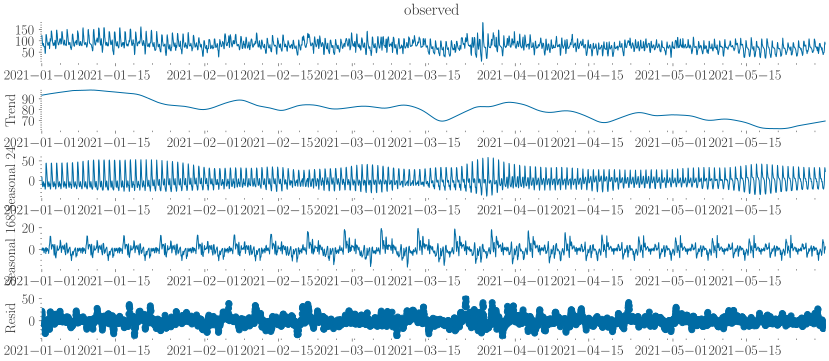

In [22]:
mstl = MSTL(timeseries["y"], periods=[24, 24 * 7], iterate=3, stl_kwargs={"seasonal_deg": 0,
                                                                          "inner_iter": 2,
                                                                          "outer_iter": 0})
res = mstl.fit() # Use .fit() to perform and return the decomposition
ax = res.plot()
plt.tight_layout()

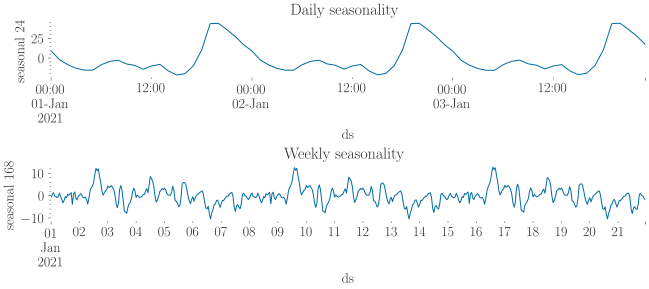

In [24]:
fig, ax = plt.subplots(nrows=2, figsize=[9,4])
res.seasonal["seasonal_24"].iloc[:24*3].plot(ax=ax[0])
ax[0].set_ylabel("seasonal_24")
ax[0].set_title("Daily seasonality")

res.seasonal["seasonal_168"].iloc[:24*7*3].plot(ax=ax[1])
ax[1].set_ylabel("seasonal_168")
ax[1].set_title("Weekly seasonality")

plt.tight_layout()

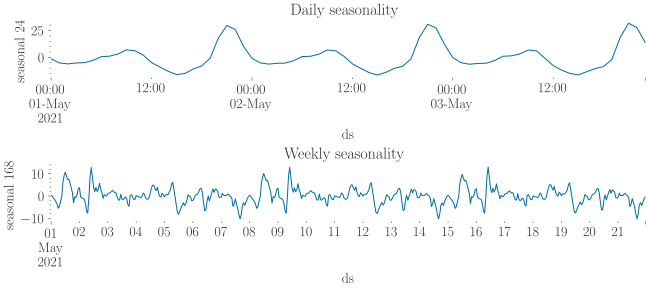

In [25]:
fig, ax = plt.subplots(nrows=2, figsize=[9,4])
mask = res.seasonal.index.month==5
res.seasonal[mask]["seasonal_24"].iloc[:24*3].plot(ax=ax[0])
ax[0].set_ylabel("seasonal_24")
ax[0].set_title("Daily seasonality")

res.seasonal[mask]["seasonal_168"].iloc[:24*7*3].plot(ax=ax[1])
ax[1].set_ylabel("seasonal_168")
ax[1].set_title("Weekly seasonality")

plt.tight_layout()
